In [1]:
import pandas as pd

# 데이터 로드, 전처리

In [4]:
# 코드맵 로드
cert_map_df = pd.read_csv('/Users/eunzinri/Desktop/DMT/자격증코드맵.csv')
major_map_df = pd.read_csv('/Users/eunzinri/Desktop/DMT/전공코드맵.csv')
# 데이터 로드
data2015 = pd.read_csv('/Users/eunzinri/Desktop/DMT/DM2015.csv')
data2016 = pd.read_csv('/Users/eunzinri/Desktop/DMT/DM2016.csv')
data2017 = pd.read_csv('/Users/eunzinri/Desktop/DMT/DM2017.csv')
data2018 = pd.read_csv('/Users/eunzinri/Desktop/DMT/DM2018.csv')
data2019 = pd.read_csv('/Users/eunzinri/Desktop/DMT/DM2019.csv')

In [6]:
# 학점 환산 함수 (학점 / 만점 * 4.5)
def convert_gpa(row):
    gpa = row['졸업 평점']
    gpa_type = row['졸업 평점 유형']
    
    if gpa_type == 3:
        return gpa
    elif gpa_type == 2:
        return (gpa / 4.3) * 4.5
    elif gpa_type == 1:
        return (gpa / 4.0) * 4.5
    else:
        return None 
        
# 전처리 함수
def preprocess(df) :

    #이진변수 설정
    binary_cols = [
        '알바 여부', '직장_요구자격증여부', '복수전공여부', '부전공여부', '졸업유예경험', '대학원경험',
        '어학연수경험','취업목표유무','구직활동경험', '자격증여부', '공모전수상', '대외활동', '면접훈련',
        '흡연여부'
    ]

    # (원데이터)1,2 -> 1,0으로 변경
    for col in binary_cols:
        if col in df.columns:
            df[col] = df[col].replace({2: 0})

    # 결측치 처리
    cols_to_fill_zero = ['월 소득','합격경험','복수전공여부','부전공여부',
                         '휴학학기수','공모전수상','대외활동','면접훈련',
                        '부모님자산규모']
    df[cols_to_fill_zero] = df[cols_to_fill_zero].fillna(0)
    df['알바 여부'] = df['알바 여부'].fillna(1)
    
    # 변수별 적절한 처리 (이상치/결측치 제거, 웬만하면 이진으로 변경)
    df['부모님자산규모'] = df['부모님자산규모'].apply(lambda x: 0 if x == -1 else x)
    df['인서울여부'] = df['학교소재'].apply(lambda x: 0 if x != 1 else 1)
    df['음주선호도'] = df['음주선호도'].apply(lambda x: 1 if x in [4, 5, 6] else 0)
    df['군복무경험'] = df['군복무경험'].apply(lambda x: 1 if x in [2,3] else 0)
    
    # 군휴학 보정
    df.loc[(df['휴학학기수'] >2) & (df['군복무경험'] == 1), '휴학학기수'] -= 3
    
    # 학점 환산(스케일링)
    df['환산 졸업평점'] = df.apply(convert_gpa, axis=1)
    
    # 합격여부(종속)변수 추가 
    df['합격여부'] = df['알바 여부'].apply(lambda x: 0 if x == 1 else 1)
    df.loc[(df['합격경험'] > 0), '합격여부'] = 1
    
    # 쓸모없는 변수 제거
    df.drop(columns=['졸업 평점 유형', '졸업 평점', '학교소재'],inplace=True)

    # 값들이 코드로 되어 있는 자격증을 파악 하기위해 한글화
    cert_map = dict(zip(cert_map_df['코드'], cert_map_df['자격증명']))
    cert_cols=['자격증_1','자격증_2','자격증_3']
    for col in cert_cols:
        df[col] = df[col].map(cert_map)

    #이진변수 불린으로 변경
    df[binary_cols] = df[binary_cols].astype(bool)

    #월 소득 이상치 처리
    df = df[df['월 소득'] < 2000]
    return df

In [8]:
# 데이터들 전처리 함수 적용
data_list = [data2015, data2016, data2017, data2018, data2019]
df2015, df2016, df2017, df2018, df2019 = [preprocess(d) for d in data_list]

In [9]:
# 자격증 코드->자격증명 (2015,2016까지만 코드로 되어있음)
major_map = dict(zip(major_map_df['코드'], major_map_df['전공명']))
df2015['전공'] = df2015['전공'].map(major_map)
df2016['전공'] = df2016['전공'].map(major_map)

/var/folders/d2/9rzglf1n68j37h1zk5c5zvkw0000gn/T/ipykernel_14425/2712900240.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2015['전공'] = df2015['전공'].map(major_map)
/var/folders/d2/9rzglf1n68j37h1zk5c5zvkw0000gn/T/ipykernel_14425/2712900240.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2016['전공'] = df2016['전공'].map(major_map)


In [12]:
# 처리 결과 확인
df2015.columns

Index(['전공', '졸업당시나이', '알바 여부', '월 소득', '직장_만족도', '직장_전공일치정도', '직장_요구자격증여부',
       '합격경험', '복수전공여부', '복수전공명', '부전공여부', '부전공명', '군복무경험', '휴학학기수', '졸업유예경험',
       '대학원경험', '재학중재직경험', '어학연수경험', '토익점수', '취업목표유무', '자격증여부', '자격증_1',
       '자격증_2', '자격증_3', '구직활동경험', '공모전수상', '대외활동', '면접훈련', '중요도_근로소득',
       '중요도_흥미', '중요도_전공관련성', '중요도_개인발전가능성', '중요도_직업자체전망', '중요도_직장안정성',
       '중요도_근무환경', '중요도_복리후생', '중요도_회사규모', '중요도_출퇴근거리', '중요도_사회적평판',
       '하루평균수면시간', '흡연여부', '음주선호도', '삶의 만족도', '부모님자산규모', '월평균생활비', '현재 건강상태',
       '인서울여부', '환산 졸업평점', '합격여부'],
      dtype='object')

In [14]:
# 산공 학생들만 추출
df_list = [df2015, df2016, df2017, df2018, df2019]
ie2015, ie2016, ie2017, ie2018, ie2019 = [df[df['전공'] == '산업공학'] for df in df_list]

In [16]:
len(ie2015),len(ie2016),len(ie2017),len(ie2018),len(ie2019)

(154, 160, 147, 193, 200)

In [18]:
# 연도별 자격증명 통일
cols = ['자격증_1', '자격증_2', '자격증_3']

for col in cols:
    ie2015[col] = ie2015[col].replace('컴활용실무능력', '컴퓨터활용능력')
    ie2015[col] = ie2015[col].replace('품질기사', '품질경영기사')
    ie2015[col] = ie2015[col].replace('워드실무능력', '워드프로세서')
    ie2015[col] = ie2015[col].replace('워드', '워드프로세서')
    
    ie2016[col] = ie2016[col].replace('컴활용실무능력', '컴퓨터활용능력')
    ie2016[col] = ie2016[col].replace('워드실무능력', '워드프로세서')

/var/folders/d2/9rzglf1n68j37h1zk5c5zvkw0000gn/T/ipykernel_14425/3582520537.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ie2015[col] = ie2015[col].replace('컴활용실무능력', '컴퓨터활용능력')
/var/folders/d2/9rzglf1n68j37h1zk5c5zvkw0000gn/T/ipykernel_14425/3582520537.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ie2015[col] = ie2015[col].replace('품질기사', '품질경영기사')
/var/folders/d2/9rzglf1n68j37h1zk5c5zvkw0000gn/T/ipykernel_14425/3582520537.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of 

In [20]:
# 연도별 데이터 하나로 통합
ie_data = pd.concat([ie2015, ie2016, ie2017, ie2018, ie2019], ignore_index=True)

In [22]:
# 자격증 변수 추가를 위한 함수 (이진변수)

def oneHotCert(df, top_n=5):
    # 자격증 컬럼 목록 고정
    cert_cols = ['자격증_1', '자격증_2', '자격증_3']

    # 1. 자격증 통합
    df['자격증_통합'] = df[cert_cols].apply(lambda row: ' '.join(row.dropna().astype(str)), axis=1)

    # 2. 상위 N개 자격증 추출
    all_certs = pd.concat([df[col] for col in cert_cols])
    top_certs = all_certs.dropna().value_counts().head(top_n).index.tolist()
    print(top_certs)

    # 3. 이진 변수 생성
    for cert in top_certs:
        df[f'자격증_{cert}'] = df['자격증_통합'].apply(lambda x: 1 if cert in x else 0)
        
    df.drop(columns=['자격증_1', '자격증_2', '자격증_3','자격증_통합'],inplace=True)

    return df

In [24]:
ie_data = oneHotCert(ie_data)

['품질경영기사', '정보처리기사', '컴퓨터활용능력', '산업안전기사', '유통관리사']


In [26]:
# 자격증 변수 추가 확인
ie_data.columns

Index(['전공', '졸업당시나이', '알바 여부', '월 소득', '직장_만족도', '직장_전공일치정도', '직장_요구자격증여부',
       '합격경험', '복수전공여부', '복수전공명', '부전공여부', '부전공명', '군복무경험', '휴학학기수', '졸업유예경험',
       '대학원경험', '재학중재직경험', '어학연수경험', '토익점수', '취업목표유무', '자격증여부', '구직활동경험',
       '공모전수상', '대외활동', '면접훈련', '중요도_근로소득', '중요도_흥미', '중요도_전공관련성',
       '중요도_개인발전가능성', '중요도_직업자체전망', '중요도_직장안정성', '중요도_근무환경', '중요도_복리후생',
       '중요도_회사규모', '중요도_출퇴근거리', '중요도_사회적평판', '하루평균수면시간', '흡연여부', '음주선호도',
       '삶의 만족도', '부모님자산규모', '월평균생활비', '현재 건강상태', '인서울여부', '환산 졸업평점', '합격여부',
       '자격증_품질경영기사', '자격증_정보처리기사', '자격증_컴퓨터활용능력', '자격증_산업안전기사', '자격증_유통관리사'],
      dtype='object')

In [28]:
# 쓸모없는(결측치가 너무 많거나, 분석에 필요없는)변수 제거
ie_data=ie_data.drop(columns=['전공','합격경험','복수전공명','부전공명','월평균생활비','토익점수'])

In [30]:
# 결측치 확인
ie_data.isna().sum()

졸업당시나이           0
알바 여부            0
월 소득             0
직장_만족도         206
직장_전공일치정도      206
직장_요구자격증여부       0
복수전공여부           0
부전공여부            0
군복무경험            0
휴학학기수            0
졸업유예경험           0
대학원경험            0
재학중재직경험          0
어학연수경험           0
취업목표유무           0
자격증여부            0
구직활동경험           0
공모전수상            0
대외활동             0
면접훈련             0
중요도_근로소득         0
중요도_흥미           0
중요도_전공관련성        0
중요도_개인발전가능성      0
중요도_직업자체전망       0
중요도_직장안정성        0
중요도_근무환경         0
중요도_복리후생         0
중요도_회사규모         0
중요도_출퇴근거리        0
중요도_사회적평판        0
하루평균수면시간         0
흡연여부             0
음주선호도            0
삶의 만족도           0
부모님자산규모          0
현재 건강상태          0
인서울여부            0
환산 졸업평점         15
합격여부             0
자격증_품질경영기사       0
자격증_정보처리기사       0
자격증_컴퓨터활용능력      0
자격증_산업안전기사       0
자격증_유통관리사        0
dtype: int64

In [32]:
# 졸업평점 결측치를 평균으로 보간
ie_data['환산 졸업평점']=ie_data['환산 졸업평점'].fillna(ie_data['환산 졸업평점'].mean())

# 졸업 후 정규직 합격여부 예측

## EDA

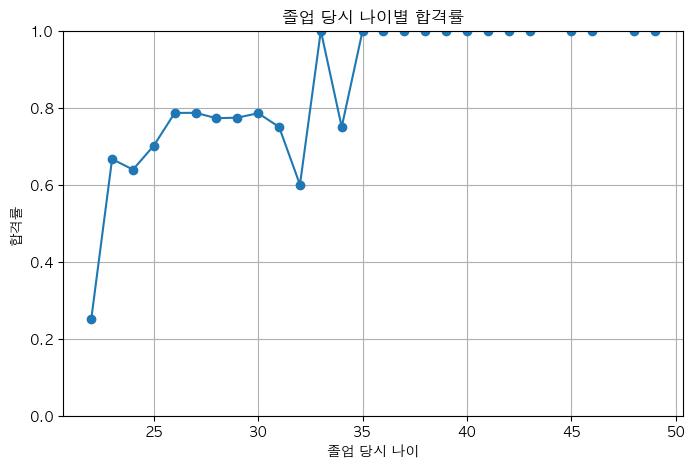

In [56]:
import matplotlib.pyplot as plt
plt.rc('font', family='AppleGothic')  # 맥에서 한글 폰트 설정
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 부호 깨짐 방지

# 나이별 평균 합격률
age_mean = ie_data.groupby('졸업당시나이')['합격여부'].mean().reset_index()

# 시각화
plt.figure(figsize=(8, 5))
plt.plot(age_mean['졸업당시나이'], age_mean['합격여부'], marker='o')
plt.xlabel('졸업 당시 나이')
plt.ylabel('합격률')
plt.title('졸업 당시 나이별 합격률')
plt.grid(True)
plt.ylim(0, 1)
plt.show()

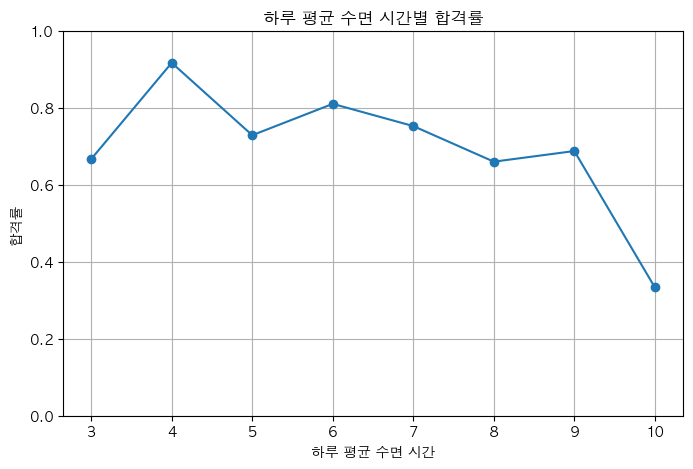

In [58]:
# 나이별 평균 합격률
age_mean = ie_data.groupby('하루평균수면시간')['합격여부'].mean().reset_index()
# 이상치 제거 (수면시간이 1시간인 사람은 한 명뿐)
age_mean = age_mean[age_mean['하루평균수면시간'] != 1]

# 시각화
plt.figure(figsize=(8, 5))
plt.plot(age_mean['하루평균수면시간'], age_mean['합격여부'], marker='o')
plt.xlabel('하루 평균 수면 시간')
plt.ylabel('합격률')
plt.title('하루 평균 수면 시간별 합격률')
plt.grid(True)
plt.ylim(0, 1)
plt.show()

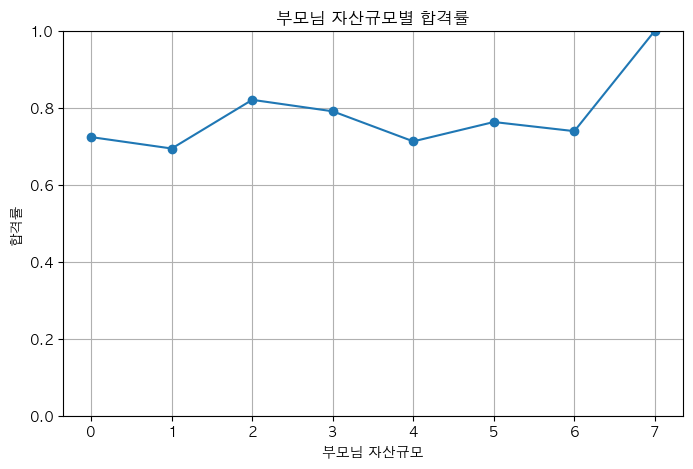

In [60]:
# 나이별 평균 합격률
age_mean = ie_data.groupby('부모님자산규모')['합격여부'].mean().reset_index()

# 시각화
plt.figure(figsize=(8, 5))
plt.plot(age_mean['부모님자산규모'], age_mean['합격여부'], marker='o')
plt.xlabel('부모님 자산규모')
plt.ylabel('합격률')
plt.title('부모님 자산규모별 합격률')
plt.grid(True)
plt.ylim(0, 1)
plt.show()

/var/folders/d2/9rzglf1n68j37h1zk5c5zvkw0000gn/T/ipykernel_14425/4172246101.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  score_bin_mean = iee.groupby('평점구간')['합격여부'].mean().reset_index()


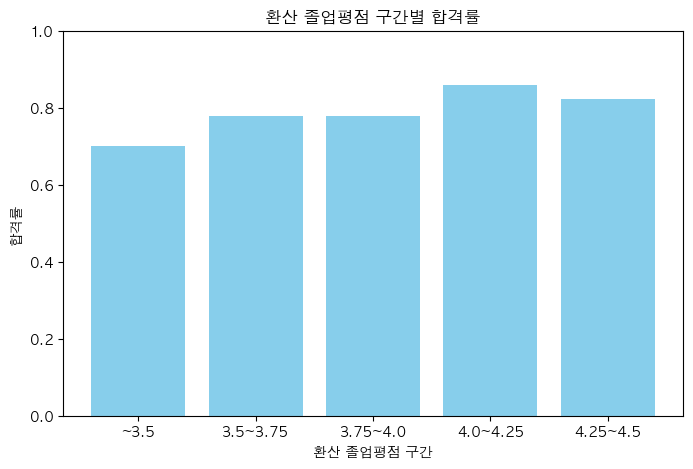

In [62]:
# 평점 구간 설정
bins = [0, 3.5, 3.75, 4.0, 4.25, 4.5]
labels = ['~3.5', '3.5~3.75', '3.75~4.0', '4.0~4.25', '4.25~4.5']
iee=ie_data.copy()
iee['평점구간'] = pd.cut(iee['환산 졸업평점'], bins=bins, labels=labels)

# 구간별 합격률
score_bin_mean = iee.groupby('평점구간')['합격여부'].mean().reset_index()

# 시각화
plt.figure(figsize=(8, 5))
plt.bar(score_bin_mean['평점구간'], score_bin_mean['합격여부'], color='skyblue')
plt.xlabel('환산 졸업평점 구간')
plt.ylabel('합격률')
plt.title('환산 졸업평점 구간별 합격률')
plt.ylim(0, 1)
plt.show()

In [64]:
iee['평점구간'].value_counts()

평점구간
~3.5        373
3.75~4.0    193
3.5~3.75    172
4.0~4.25     71
4.25~4.5     45
Name: count, dtype: int64

In [66]:
# 구간별로 인서울여부 비율 계산
for grade_bin in ['4.0~4.25', '4.25~4.5']:
    subset = iee[iee['평점구간'] == grade_bin]
    ratio = subset['인서울여부'].value_counts(normalize=True)
    print(f"평점구간: {grade_bin}")
    print(ratio)
    print()

평점구간: 4.0~4.25
인서울여부
0    0.535211
1    0.464789
Name: proportion, dtype: float64

평점구간: 4.25~4.5
인서울여부
0    0.777778
1    0.222222
Name: proportion, dtype: float64



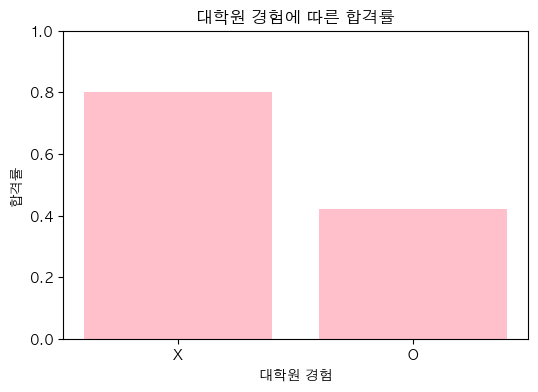

In [68]:
# 흡연여부별 평균 합격률 계산
aca_mean = ie_data.groupby('대학원경험')['합격여부'].mean().reset_index()

# 시각화
plt.figure(figsize=(6, 4))
plt.bar(aca_mean['대학원경험'], aca_mean['합격여부'], color='pink')
plt.xticks([0, 1], ['X', 'O'])
plt.xlabel('대학원 경험')
plt.ylabel('합격률')
plt.title('대학원 경험에 따른 합격률')
plt.ylim(0, 1)
plt.show()

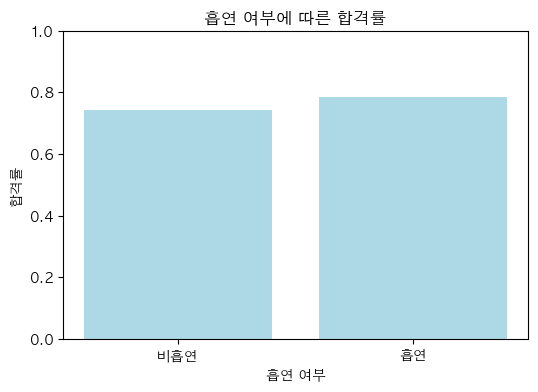

In [70]:
# 흡연여부별 평균 합격률 계산
smoke_mean = ie_data.groupby('흡연여부')['합격여부'].mean().reset_index()

# 시각화
plt.figure(figsize=(6, 4))
plt.bar(smoke_mean['흡연여부'], smoke_mean['합격여부'], color='lightblue')
plt.xticks([0, 1], ['비흡연', '흡연'])
plt.xlabel('흡연 여부')
plt.ylabel('합격률')
plt.title('흡연 여부에 따른 합격률')
plt.ylim(0, 1)
plt.show()

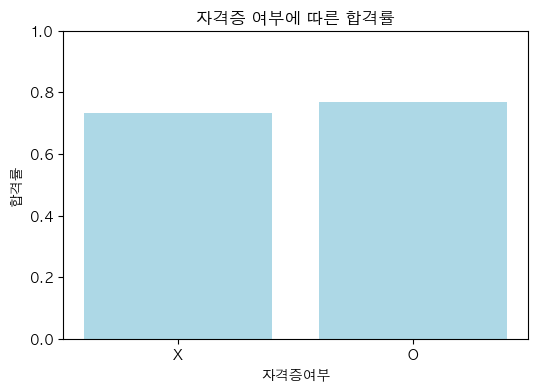

In [72]:
# 흡연여부별 평균 합격률 계산
in_mean = ie_data.groupby('자격증여부')['합격여부'].mean().reset_index()

# 시각화
plt.figure(figsize=(6, 4))
plt.bar(in_mean['자격증여부'], in_mean['합격여부'], color='lightblue')
plt.xticks([0, 1], ['X', 'O'])
plt.xlabel('자격증여부')
plt.ylabel('합격률')
plt.title('자격증 여부에 따른 합격률')
plt.ylim(0, 1)
plt.show()

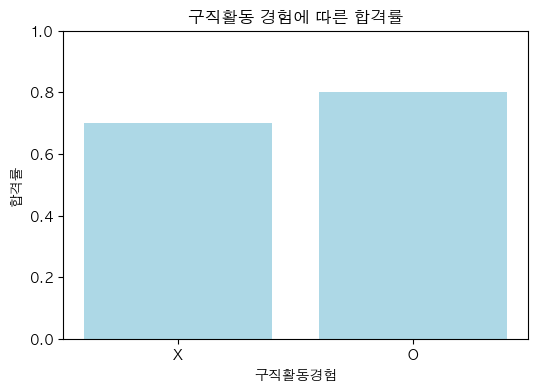

In [74]:
# 흡연여부별 평균 합격률 계산
in_mean = ie_data.groupby('구직활동경험')['합격여부'].mean().reset_index()

# 시각화
plt.figure(figsize=(6, 4))
plt.bar(in_mean['구직활동경험'], in_mean['합격여부'], color='lightblue')
plt.xticks([0, 1], ['X', 'O'])
plt.xlabel('구직활동경험')
plt.ylabel('합격률')
plt.title('구직활동 경험에 따른 합격률')
plt.ylim(0, 1)
plt.show()

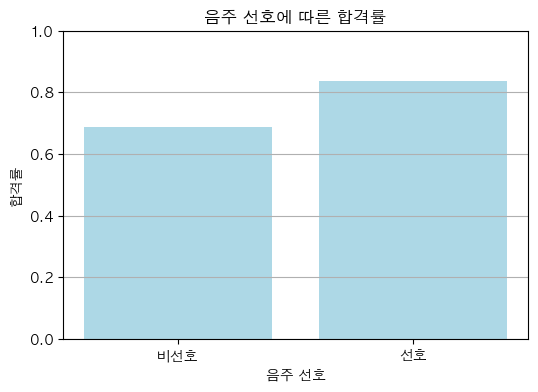

In [76]:
# 음주선호도별 평균 합격률 계산
drink_mean = ie_data.groupby('음주선호도')['합격여부'].mean().reset_index()

# 시각화
plt.figure(figsize=(6, 4))
plt.bar(drink_mean['음주선호도'], drink_mean['합격여부'], color='lightblue')
plt.xlabel('음주 선호')
plt.xticks([0, 1], ['비선호', '선호'])
plt.ylabel('합격률')
plt.title('음주 선호에 따른 합격률')
plt.ylim(0, 1)
plt.grid(True, axis='y')

# 음주 선호도가 정수형이면 축 레이블 지정
if ie_data['음주선호도'].nunique() <= 5:
    plt.xticks(drink_mean['음주선호도'])

plt.show()

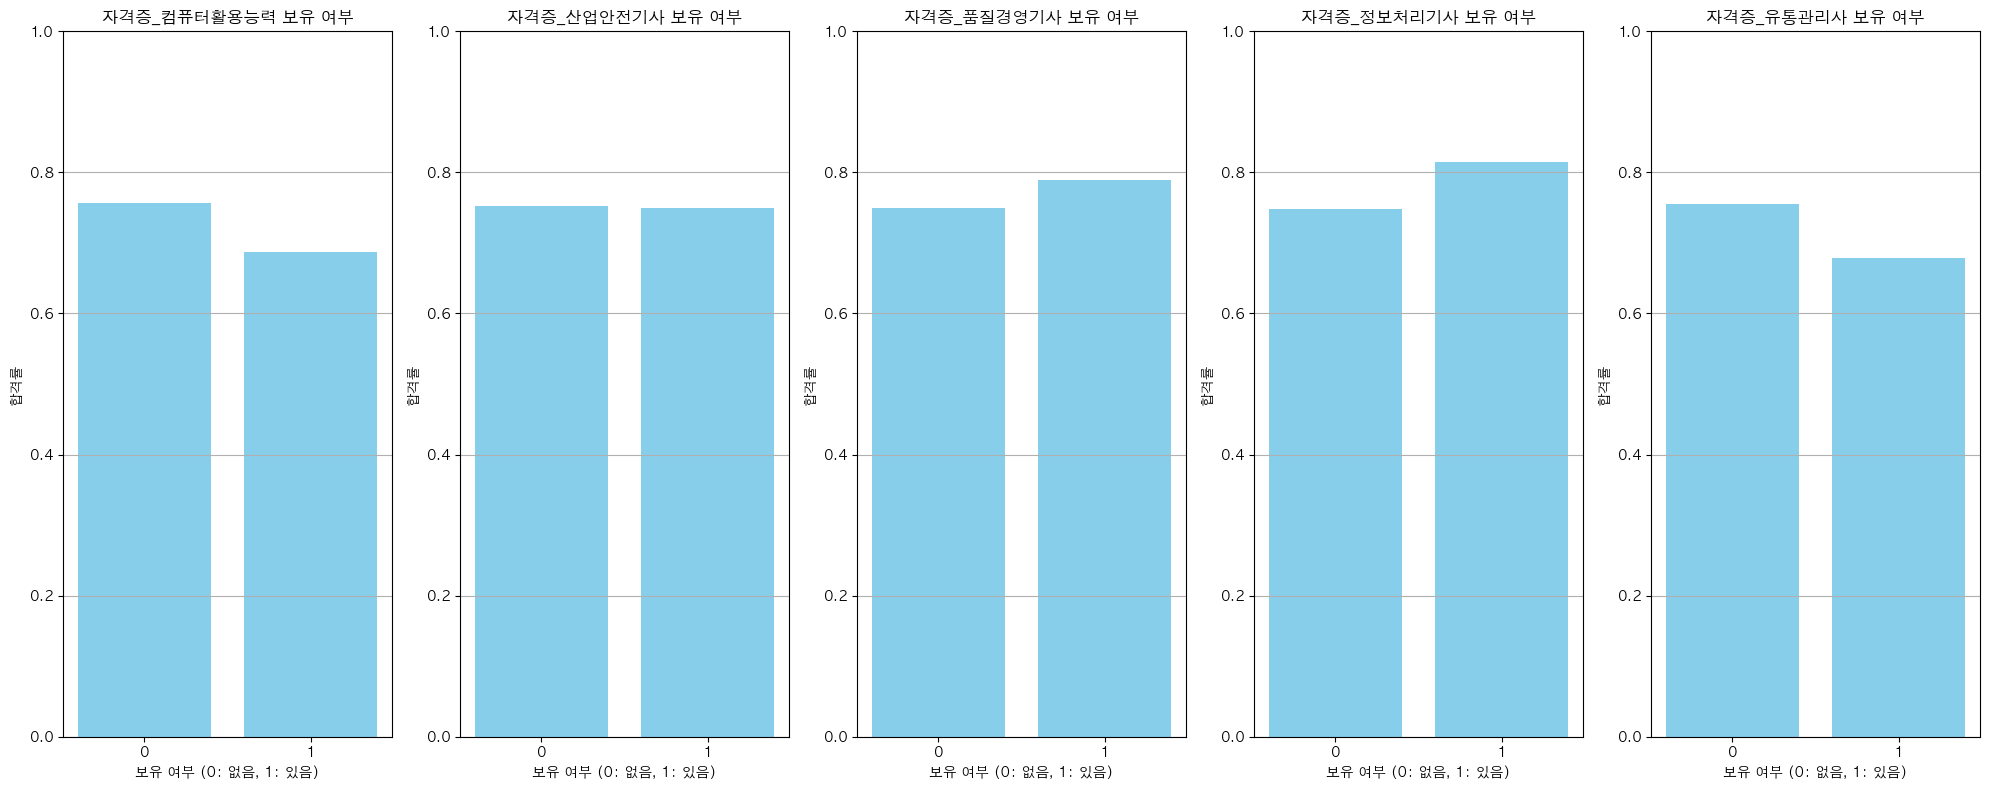

In [78]:
import matplotlib.pyplot as plt

# 자격증 컬럼 리스트
cert_columns = [
    '자격증_컴퓨터활용능력',
    '자격증_산업안전기사',
    '자격증_품질경영기사',
    '자격증_정보처리기사',
    '자격증_유통관리사'
]

# 시각화: 각 자격증별로 평균 합격률 계산 및 시각화
fig, axes = plt.subplots(1, 5, figsize=(20, 8))
axes = axes.flatten()

for i, col in enumerate(cert_columns):
    cert_mean = ie_data.groupby(col)['합격여부'].mean()
    axes[i].bar(cert_mean.index.astype(str), cert_mean.values, color='skyblue')
    axes[i].set_title(f'{col} 보유 여부')
    axes[i].set_xlabel('보유 여부 (0: 없음, 1: 있음)')
    axes[i].set_ylabel('합격률')
    axes[i].set_ylim(0, 1)
    axes[i].grid(True, axis='y')

plt.tight_layout()
plt.show()

In [80]:
ie_data.columns

Index(['졸업당시나이', '알바 여부', '월 소득', '직장_만족도', '직장_전공일치정도', '직장_요구자격증여부',
       '복수전공여부', '부전공여부', '군복무경험', '휴학학기수', '졸업유예경험', '대학원경험', '재학중재직경험',
       '어학연수경험', '취업목표유무', '자격증여부', '구직활동경험', '공모전수상', '대외활동', '면접훈련',
       '중요도_근로소득', '중요도_흥미', '중요도_전공관련성', '중요도_개인발전가능성', '중요도_직업자체전망',
       '중요도_직장안정성', '중요도_근무환경', '중요도_복리후생', '중요도_회사규모', '중요도_출퇴근거리',
       '중요도_사회적평판', '하루평균수면시간', '흡연여부', '음주선호도', '삶의 만족도', '부모님자산규모',
       '현재 건강상태', '인서울여부', '환산 졸업평점', '합격여부', '자격증_품질경영기사', '자격증_정보처리기사',
       '자격증_컴퓨터활용능력', '자격증_산업안전기사', '자격증_유통관리사'],
      dtype='object')

In [82]:
# 종속변수 설정
y = ie_data['합격여부']

# 독립변수 설정 (직장인 대상으로 진행한 설문 결과는 제외, 종속변수와 직접적으로 연관 되어있는 변수들 제거)
X = ie_data.drop(columns=['알바 여부','합격여부',
                          '월 소득','직장_만족도', '직장_전공일치정도', '직장_요구자격증여부',
                         '중요도_근로소득', '중요도_흥미', '중요도_전공관련성', '중요도_개인발전가능성',
       '중요도_직업자체전망', '중요도_직장안정성', '중요도_근무환경', '중요도_복리후생', '중요도_회사규모',
       '중요도_출퇴근거리', '중요도_사회적평판'])

In [84]:
# 최종 변수 확인
X.columns

Index(['졸업당시나이', '복수전공여부', '부전공여부', '군복무경험', '휴학학기수', '졸업유예경험', '대학원경험',
       '재학중재직경험', '어학연수경험', '취업목표유무', '자격증여부', '구직활동경험', '공모전수상', '대외활동',
       '면접훈련', '하루평균수면시간', '흡연여부', '음주선호도', '삶의 만족도', '부모님자산규모', '현재 건강상태',
       '인서울여부', '환산 졸업평점', '자격증_품질경영기사', '자격증_정보처리기사', '자격증_컴퓨터활용능력',
       '자격증_산업안전기사', '자격증_유통관리사'],
      dtype='object')

## Decision Tree (베이스모델)

In [79]:
### 베이스라인을 잡기 위한 디시전트리 분석 진행
### 그래도 GridSearch를 통해 최적의 하이퍼파라미터를 찾아 진행

# from sklearn.tree import DecisionTreeClassifier
# from sklearn.model_selection import StratifiedKFold
# from sklearn.metrics import accuracy_score
# import pandas as pd
# import numpy as np

# # 하이퍼파라미터 후보 리스트
# max_depth_list = [4,5,6,7,8,9,10,None]
# min_samples_split_list = [2,3,4,5,6,7,8,9,10]
# min_samples_leaf_list = [1,2,3,4,5,6,7,8,9,10]

# # Stratified K-Fold
# skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# results = []

# for max_depth in max_depth_list:
#     for min_samples_split in min_samples_split_list:
#         for min_samples_leaf in min_samples_leaf_list:
            
#             train_acc_list = []
#             valid_acc_list = []
            
#             for train_idx, valid_idx in skf.split(X, y):
#                 X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
#                 y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]
                
#                 model = DecisionTreeClassifier(
#                     max_depth=max_depth,
#                     min_samples_split=min_samples_split,
#                     min_samples_leaf=min_samples_leaf,
#                     random_state=42
#                 )
#                 model.fit(X_train, y_train)
                
#                 train_pred = model.predict(X_train)
#                 valid_pred = model.predict(X_valid)
                
#                 train_acc_list.append(accuracy_score(y_train, train_pred))
#                 valid_acc_list.append(accuracy_score(y_valid, valid_pred))
            
#             results.append({
#                 'max_depth': max_depth,
#                 'min_samples_split': min_samples_split,
#                 'min_samples_leaf': min_samples_leaf,
#                 'train_accuracy_mean': np.mean(train_acc_list),
#                 'valid_accuracy_mean': np.mean(valid_acc_list)
#             })

# results_df = pd.DataFrame(results)
# results_df = results_df.sort_values(by='valid_accuracy_mean', ascending=False).reset_index(drop=True)

# print(results_df)

In [86]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

dt_final = DecisionTreeClassifier(max_depth=5,min_samples_split=10,min_samples_leaf=2
                                      ,random_state=42)
dt_final.fit(X, y)

y_pred = dt_final.predict(X)

print("Accuracy:", accuracy_score(y, y_pred))
print("\nClassification Report:\n", classification_report(y, y_pred))

#중요도 상위 10개
feat_imp_df = pd.DataFrame({
    'feature': X.columns,
    'importance': dt_final.feature_importances_
}).sort_values(by='importance', ascending=False)

print(feat_imp_df.head(30))

Accuracy: 0.8208430913348946

Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.38      0.51       211
           1       0.83      0.97      0.89       643

    accuracy                           0.82       854
   macro avg       0.81      0.67      0.70       854
weighted avg       0.82      0.82      0.80       854

        feature  importance
6         대학원경험    0.312010
22      환산 졸업평점    0.179846
17        음주선호도    0.120403
15     하루평균수면시간    0.097682
4         휴학학기수    0.060414
7       재학중재직경험    0.055884
0        졸업당시나이    0.035638
14         면접훈련    0.035242
20      현재 건강상태    0.031171
21        인서울여부    0.028187
19      부모님자산규모    0.022518
11       구직활동경험    0.021007
8        어학연수경험    0.000000
26   자격증_산업안전기사    0.000000
25  자격증_컴퓨터활용능력    0.000000
24   자격증_정보처리기사    0.000000
23   자격증_품질경영기사    0.000000
2         부전공여부    0.000000
18       삶의 만족도    0.000000
9        취업목표유무    0.000000
3         군복무경험    0.000000
16 

## 위는 하나의 디시전트리로 진행한 결과이다.
## 밑엔 여러 디시전트리로 다양한 변수를 사용하기 위해 랜덤포레스트를 이용하였다.

### RandomForest

In [48]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# 파라미터 후보 정의
param_grid = {
    'n_estimators': [50, 100, 200, 300, 500],                  # 트리 개수
    'max_depth': [None, 5, 10, 15, 20, 30],                    # 트리 최대 깊이
    'min_samples_split': [2, 5, 10, 15],                       # 내부 노드 분할 최소 샘플 수
    'min_samples_leaf': [1, 2, 4, 6],                          # 리프 노드 최소 샘플 수
    'criterion': ['gini', 'entropy', 'log_loss'],             # 분할 기준
}

# 모델과 GridSearchCV 정의
rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,  # 5-fold 교차검증
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

# 학습
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
grid_search.fit(X_train, y_train)

# 최적 파라미터 및 정확도 출력
print("✅ 최적 하이퍼파라미터:", grid_search.best_params_)
print("🎯 최적 교차검증 정확도:", grid_search.best_score_)

# 최적 모델로 테스트셋 평가
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

Fitting 5 folds for each of 1440 candidates, totalling 7200 fits
✅ 최적 하이퍼파라미터: {'criterion': 'entropy', 'max_depth': 15, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 50}
🎯 최적 교차검증 정확도: 0.7760090167453843


In [88]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 최적 하이퍼파라미터로 모델 생성
best_model = RandomForestClassifier(
    class_weight=None,
    criterion='entropy',
    max_depth=15,
    min_samples_leaf=2,
    min_samples_split=10,
    n_estimators=50,
    random_state=42
)

# 학습
best_model.fit(X_train, y_train)

# 예측 및 평가
from sklearn.metrics import classification_report, accuracy_score

y_pred = best_model.predict(X_test)

print("✅ 정확도:", accuracy_score(y_test, y_pred))

✅ 정확도: 0.7777777777777778


        Feature  Importance
22      환산 졸업평점    0.133280
6         대학원경험    0.103087
0        졸업당시나이    0.091742
19      부모님자산규모    0.073212
15     하루평균수면시간    0.069978
4         휴학학기수    0.069208
18       삶의 만족도    0.057734
20      현재 건강상태    0.048751
17        음주선호도    0.047207
11       구직활동경험    0.026854
16         흡연여부    0.021840
7       재학중재직경험    0.021777
10        자격증여부    0.020908
21        인서울여부    0.020711
9        취업목표유무    0.020245
14         면접훈련    0.019031
5        졸업유예경험    0.018840
3         군복무경험    0.016471
12        공모전수상    0.015132
13         대외활동    0.013698
8        어학연수경험    0.013385
27    자격증_유통관리사    0.012122
26   자격증_산업안전기사    0.011798
23   자격증_품질경영기사    0.011624
24   자격증_정보처리기사    0.011493
1        복수전공여부    0.011125
25  자격증_컴퓨터활용능력    0.011023
2         부전공여부    0.007723


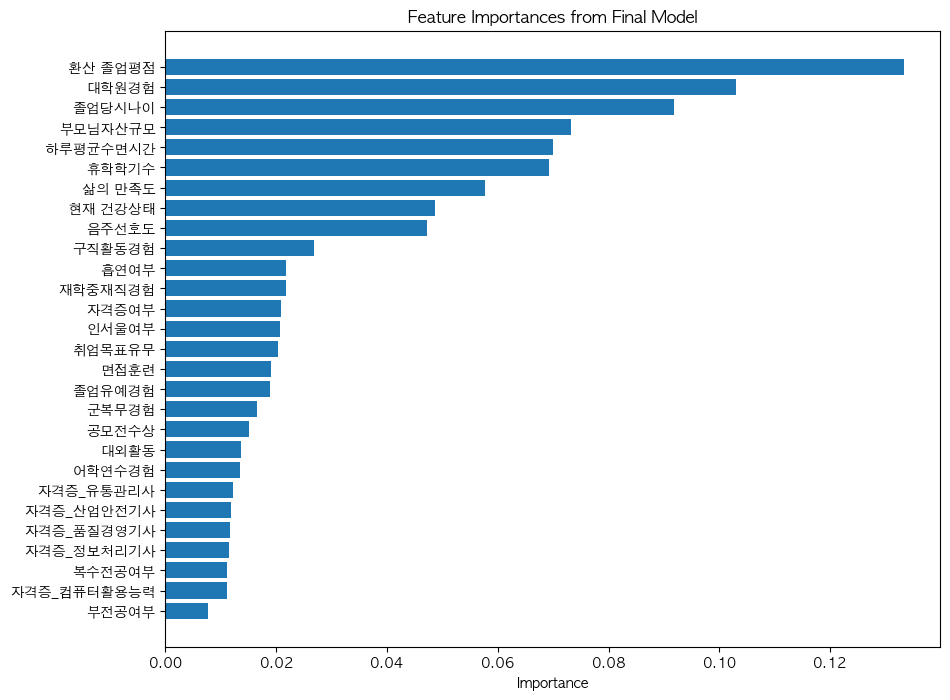

In [90]:
import pandas as pd
import matplotlib.pyplot as plt
plt.rc('font', family='AppleGothic')  # 맥에서 한글 폰트 설정
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 부호 깨짐 방지

# 최종 모델 학습
final_model = RandomForestClassifier(
    class_weight=None,
    criterion='entropy',
    max_depth=10,
    min_samples_leaf=1,
    min_samples_split=5,
    n_estimators=200,
    random_state=42
)
final_model.fit(X, y)  # 전체 데이터로 학습

# 변수 중요도 추출
importances = final_model.feature_importances_
feature_names = X.columns

# 데이터프레임으로 정리하고 중요도 순 정렬
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)
 
# 출력
print(importance_df)

# 시각화
plt.figure(figsize=(10, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.gca().invert_yaxis()  # 중요도 높은 변수 위로
plt.xlabel('Importance')
plt.title('Feature Importances from Final Model')
plt.show()

## SHAP을 이용하여 변수 영향 확인

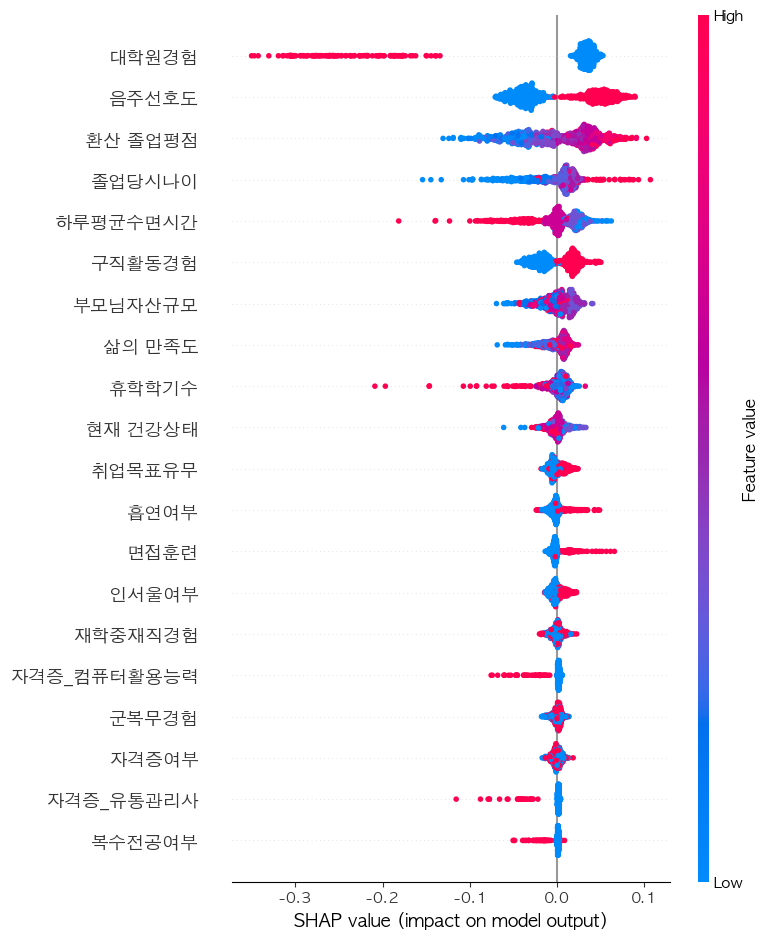

In [92]:
import shap

# TreeExplainer 사용 (RandomForest에 적합)
explainer = shap.TreeExplainer(final_model)
shap_values = explainer.shap_values(X)  # 전체 샘플에 대해 SHAP 값 계산

# shap_values 특징 수
num_features = shap_values.shape[1]  # 29

# X에서 처음 29개 컬럼만 추출 (정확한 컬럼을 알고 싶으면 따로 확인 필요)
X_subset = X.iloc[:, :num_features]

# 클래스 1에 대한 shap 값으로 summary plot 그리기
shap.summary_plot(shap_values[:, :, 1], X_subset)

# 산공 졸업 정규직 취업자들 고연봉/저연봉 예측

In [94]:
# 알바 여부 변수로 정규직 취업자 구분
ie_ft,ie_pt = ie_data[ie_data['알바 여부']==False], ie_data[ie_data['알바 여부']==True]

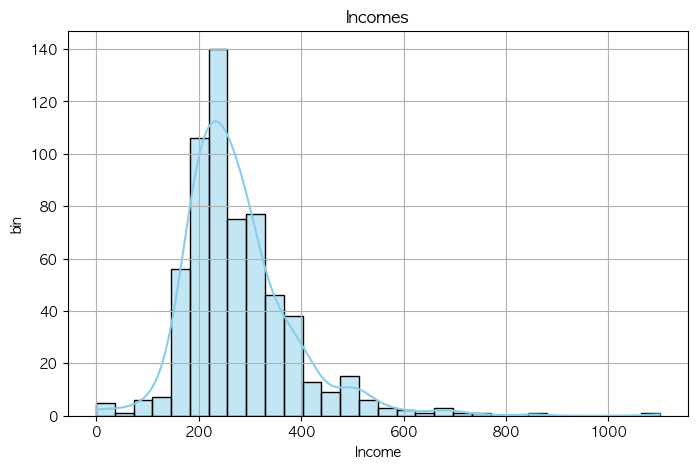

In [96]:
import matplotlib.pyplot as plt
import seaborn as sns

# 월소득 히스토그램

plt.figure(figsize=(8, 5))
sns.histplot(ie_ft['월 소득'], bins=30, kde=True, color='skyblue')
plt.title('Incomes')
plt.xlabel('Income')
plt.ylabel('bin')
plt.grid(True)
plt.show()

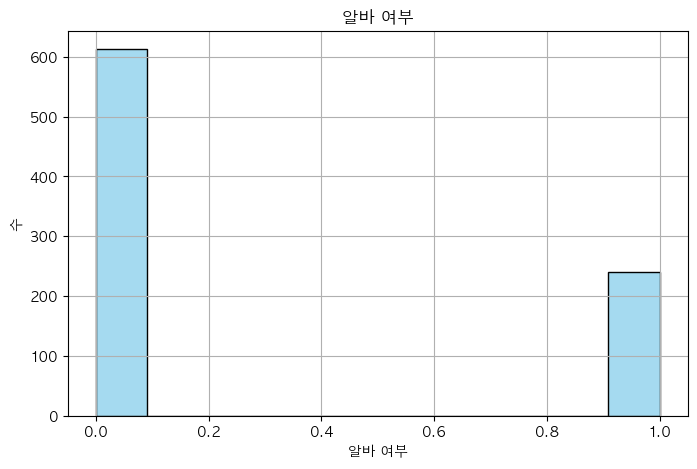

In [98]:
import matplotlib.pyplot as plt
import seaborn as sns

# 정규직/비정규직 비율 확인

plt.figure(figsize=(8, 5))
sns.histplot(ie_data['알바 여부'],color='skyblue')
plt.title('알바 여부')
plt.xlabel('알바 여부')
plt.ylabel('수')
plt.grid(True)
plt.show()

### 월소득 300 이상을 고연봉으로 구분

In [102]:
ie_ft['고연봉여부'] = (ie_ft['월 소득'] >= 300).astype(int)

/var/folders/d2/9rzglf1n68j37h1zk5c5zvkw0000gn/T/ipykernel_14425/1134431696.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ie_ft['고연봉여부'] = (ie_ft['월 소득'] >= 300).astype(int)


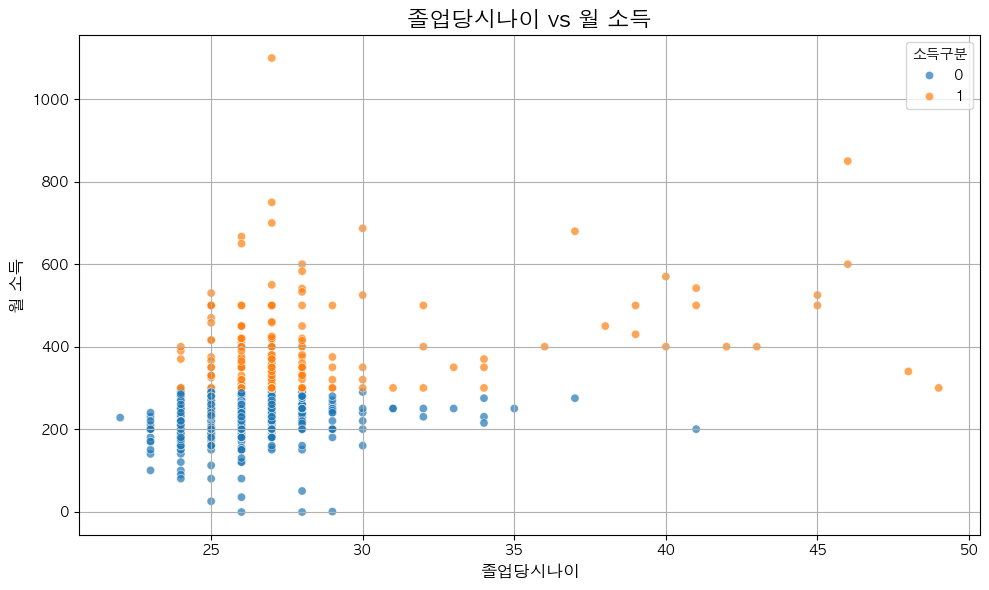

In [108]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.scatterplot(data=ie_ft, x='졸업당시나이', y='월 소득', hue='고연봉여부', alpha=0.7)

plt.title('졸업당시나이 vs 월 소득', fontsize=16)
plt.xlabel('졸업당시나이', fontsize=12)
plt.ylabel('월 소득', fontsize=12)
plt.grid(True)
plt.legend(title='소득구분')
plt.tight_layout()
plt.show()

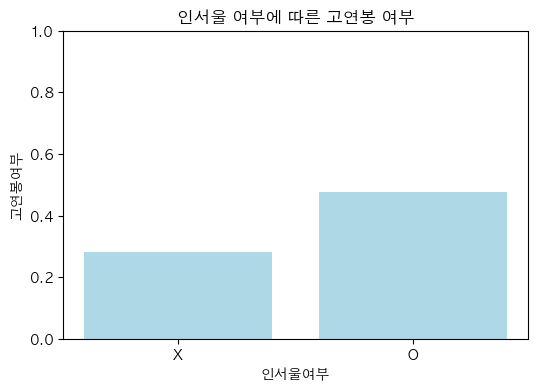

In [110]:
# 인서울 여부에 따른 고연봉 여부
aca_mean = ie_ft.groupby('인서울여부')['고연봉여부'].mean().reset_index()

# 시각화
plt.figure(figsize=(6, 4))
plt.bar(aca_mean['인서울여부'], aca_mean['고연봉여부'], color='lightblue')
plt.xticks([0, 1], ['X', 'O'])
plt.xlabel('인서울여부')
plt.ylabel('고연봉여부')
plt.title('인서울 여부에 따른 고연봉 여부')
plt.ylim(0, 1)
plt.show()

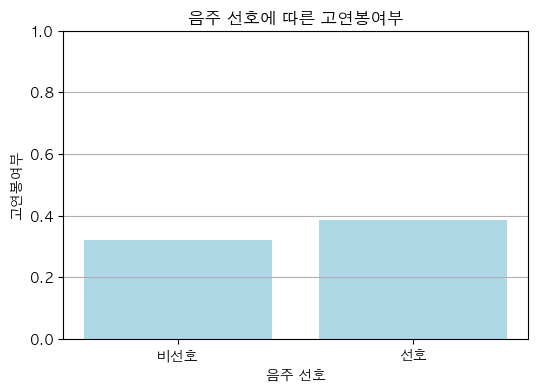

In [112]:
# 음주선호도별 평균 합격률 계산
drink_mean = ie_ft.groupby('음주선호도')['고연봉여부'].mean().reset_index()

# 시각화
plt.figure(figsize=(6, 4))
plt.bar(drink_mean['음주선호도'], drink_mean['고연봉여부'], color='lightblue')
plt.xlabel('음주 선호')
plt.xticks([0, 1], ['비선호', '선호'])
plt.ylabel('고연봉여부')
plt.title('음주 선호에 따른 고연봉여부')
plt.ylim(0, 1)
plt.grid(True, axis='y')

# 음주 선호도가 정수형이면 축 레이블 지정
if ie_data['음주선호도'].nunique() <= 5:
    plt.xticks(drink_mean['음주선호도'])

plt.show()

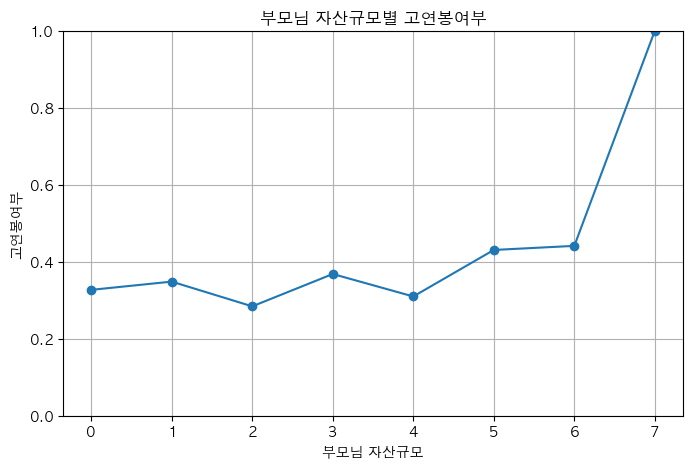

In [114]:
# 나이별 평균 합격률
age_mean = ie_ft.groupby('부모님자산규모')['고연봉여부'].mean().reset_index()

# 시각화
plt.figure(figsize=(8, 5))
plt.plot(age_mean['부모님자산규모'], age_mean['고연봉여부'], marker='o')
plt.xlabel('부모님 자산규모')
plt.ylabel('고연봉여부')
plt.title('부모님 자산규모별 고연봉여부')
plt.grid(True)
plt.ylim(0, 1)
plt.show()

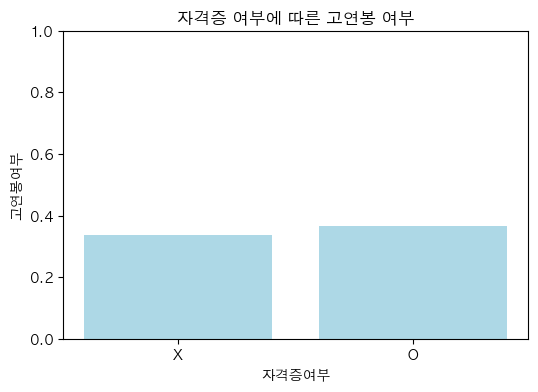

In [116]:
# 인서울 여부에 따른 고연봉 여부
aca_mean = ie_ft.groupby('자격증여부')['고연봉여부'].mean().reset_index()

# 시각화
plt.figure(figsize=(6, 4))
plt.bar(aca_mean['자격증여부'], aca_mean['고연봉여부'], color='lightblue')
plt.xticks([0, 1], ['X', 'O'])
plt.xlabel('자격증여부')
plt.ylabel('고연봉여부')
plt.title('자격증 여부에 따른 고연봉 여부')
plt.ylim(0, 1)
plt.show()

In [106]:
X=ie_ft.copy()

In [118]:
# 종속변수를 고연봉 여부로 설정
y = X['고연봉여부']

# 필요없거나 종속변수와 직접적인 영향이 있는 변수 제거
X = X.drop(columns=['고연봉여부','월 소득','알바 여부','합격여부','직장_만족도','중요도_근로소득'])

In [120]:
# 최종 변수 확인
X.columns

Index(['졸업당시나이', '직장_전공일치정도', '직장_요구자격증여부', '복수전공여부', '부전공여부', '군복무경험',
       '휴학학기수', '졸업유예경험', '대학원경험', '재학중재직경험', '어학연수경험', '취업목표유무', '자격증여부',
       '구직활동경험', '공모전수상', '대외활동', '면접훈련', '중요도_흥미', '중요도_전공관련성', '중요도_개인발전가능성',
       '중요도_직업자체전망', '중요도_직장안정성', '중요도_근무환경', '중요도_복리후생', '중요도_회사규모',
       '중요도_출퇴근거리', '중요도_사회적평판', '하루평균수면시간', '흡연여부', '음주선호도', '삶의 만족도',
       '부모님자산규모', '현재 건강상태', '인서울여부', '환산 졸업평점', '자격증_품질경영기사', '자격증_정보처리기사',
       '자격증_컴퓨터활용능력', '자격증_산업안전기사', '자격증_유통관리사'],
      dtype='object')

In [124]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# 파라미터 후보 정의
param_grid = {
    'n_estimators': [50, 100, 200, 300, 500],                  # 트리 개수
    'max_depth': [None, 5, 10, 15, 20, 30],                    # 트리 최대 깊이
    'min_samples_split': [2, 5, 10, 15],                       # 내부 노드 분할 최소 샘플 수
    'min_samples_leaf': [1, 2, 4, 6],                          # 리프 노드 최소 샘플 수
    'criterion': ['gini', 'entropy', 'log_loss'],             # 분할 기준
}

# 모델과 GridSearchCV 정의
rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,  # 5-fold 교차검증
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

# 학습
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
grid_search.fit(X_train, y_train)

# 최적 파라미터 및 정확도 출력
print("✅ 최적 하이퍼파라미터:", grid_search.best_params_)
print("🎯 최적 교차검증 정확도:", grid_search.best_score_)

# 최적 모델로 테스트셋 평가
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

Fitting 5 folds for each of 1440 candidates, totalling 7200 fits
✅ 최적 하이퍼파라미터: {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 50}
🎯 최적 교차검증 정확도: 0.6714285714285715


In [128]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 최적 하이퍼파라미터로 모델 생성
best_model = RandomForestClassifier(
    criterion='entropy',
    max_depth=None,
    min_samples_leaf=2,
    min_samples_split=2,
    n_estimators=50,
    random_state=42
)

# 학습
best_model.fit(X_train, y_train)

# 예측 및 평가
from sklearn.metrics import classification_report, accuracy_score

y_pred = best_model.predict(X_test)

print("✅ 정확도:", accuracy_score(y_test, y_pred))

✅ 정확도: 0.6991869918699187


        Feature  Importance
0        졸업당시나이    0.095639
34      환산 졸업평점    0.082124
31      부모님자산규모    0.053707
6         휴학학기수    0.047751
30       삶의 만족도    0.043443
1     직장_전공일치정도    0.042930
27     하루평균수면시간    0.041834
33        인서울여부    0.041695
24     중요도_회사규모    0.037003
25    중요도_출퇴근거리    0.035330
26    중요도_사회적평판    0.034083
32      현재 건강상태    0.032065
18    중요도_전공관련성    0.028977
5         군복무경험    0.027917
17       중요도_흥미    0.026658
21    중요도_직장안정성    0.025463
23     중요도_복리후생    0.023529
20   중요도_직업자체전망    0.022056
22     중요도_근무환경    0.021992
13       구직활동경험    0.020225
19  중요도_개인발전가능성    0.019242
29        음주선호도    0.018795
9       재학중재직경험    0.017144
12        자격증여부    0.016318
11       취업목표유무    0.015950
7        졸업유예경험    0.015584
28         흡연여부    0.013427
16         면접훈련    0.013236
2    직장_요구자격증여부    0.012761
8         대학원경험    0.011790
10       어학연수경험    0.011717
14        공모전수상    0.010708
36   자격증_정보처리기사    0.008347
4         부전공여부    0.007425
15         대외활동    0

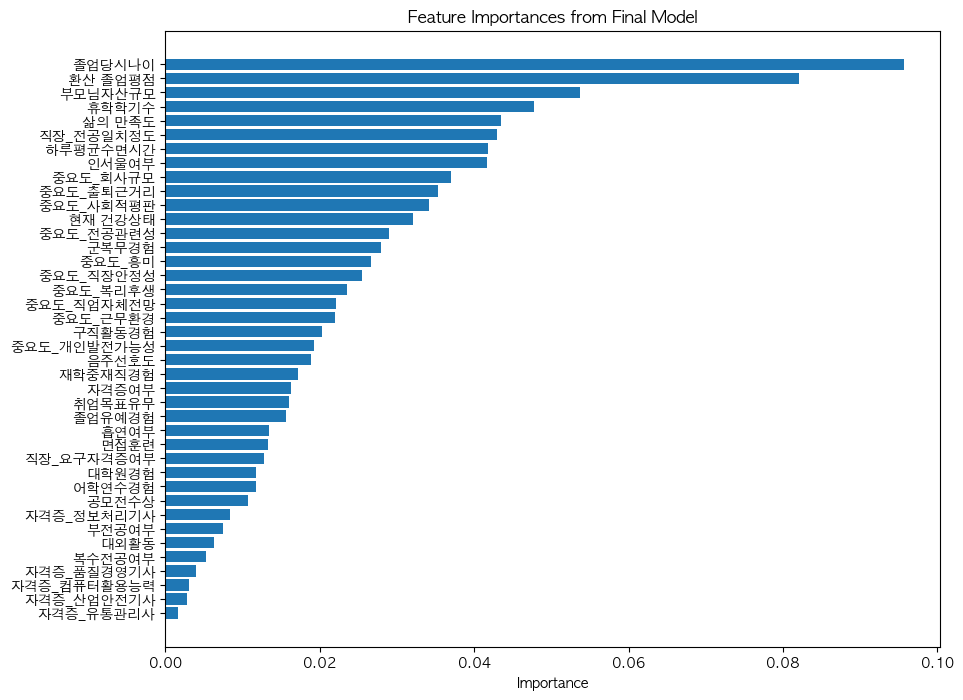

In [130]:
import pandas as pd
import matplotlib.pyplot as plt

# 최종 모델 학습 (이미 하셨다면 생략 가능)
final_model = RandomForestClassifier(
    criterion='entropy',
    max_depth=None,
    min_samples_leaf=2,
    min_samples_split=2,
    n_estimators=50,
    random_state=42
)
final_model.fit(X, y)  # 전체 데이터로 학습

# 변수 중요도 추출
importances = final_model.feature_importances_
feature_names = X.columns

# 데이터프레임으로 정리하고 중요도 순 정렬
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)
 
# 출력
print(importance_df)

# 시각화
plt.figure(figsize=(10, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.gca().invert_yaxis()  # 중요도 높은 변수 위로
plt.xlabel('Importance')
plt.title('Feature Importances from Final Model')
plt.show()


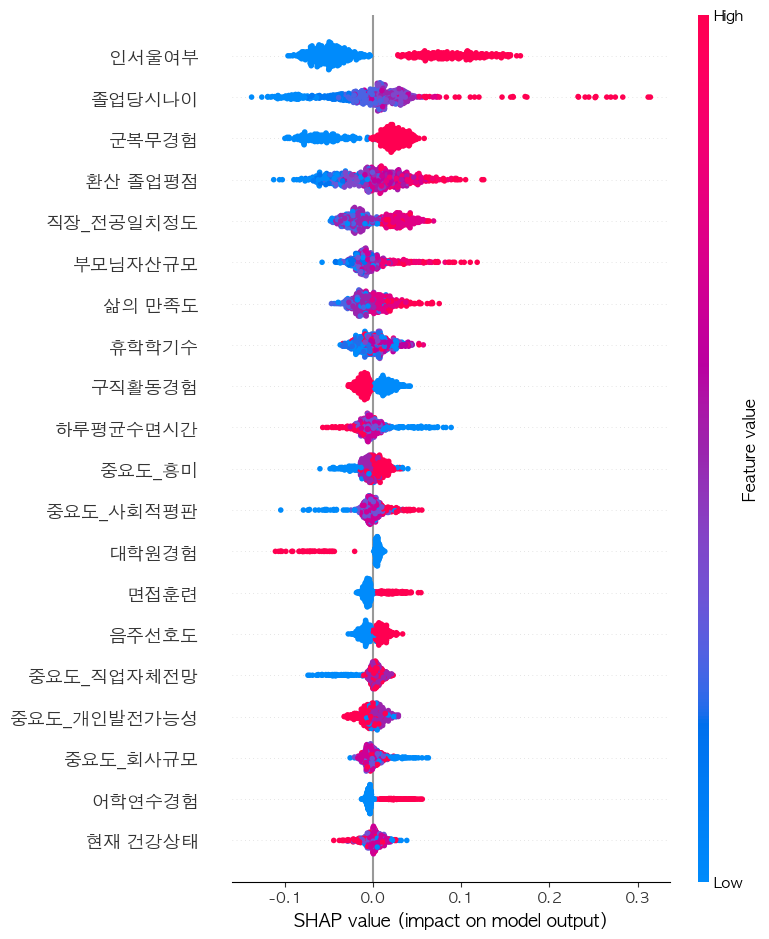

In [132]:
import shap

# TreeExplainer 사용 (RandomForest에 적합)
explainer = shap.TreeExplainer(final_model)
shap_values = explainer.shap_values(X)  # 전체 샘플에 대해 SHAP 값 계산

# shap_values 특징 수
num_features = shap_values.shape[1]  # 29

# X에서 처음 29개 컬럼만 추출 (정확한 컬럼을 알고 싶으면 따로 확인 필요)
X_subset = X.iloc[:, :num_features]

# 클래스 1에 대한 shap 값으로 summary plot 그리기
shap.summary_plot(shap_values[:, :, 1], X_subset)